In [3]:
import numpy as np
import os, os.path
from PIL import Image
from numpy import moveaxis
import matplotlib.pyplot as plt  ## 231 to 569
import sys
import random

# Defining some simple functions to convert image files to labeled arrays
> Filename of each image was the x_co-ordinate of the mouse (corresponding label)

In [2]:
def generate_train_data(source_folder, save_path):
    
    final_stack = []
    for i in os.listdir(source_folder):   # i is the img_name btw
        
        im_path = source_folder + "/" + i
        label = int(i[:3])
        im_arr = img_to_arr(im_path)
        stack_element = [im_arr, label]
        stack_element = np.array(stack_element)
        final_stack.append(stack_element)
    final_stack = np.array(final_stack)
    print (final_stack.shape[0], " instances ")
    fmt_name = save_path
    np.save(fmt_name, final_stack)
    print ("saved -- ", fmt_name)

def img_to_arr(im_path):

    img = Image.open(im_path)
    x = np.array(img)
    x = moveaxis(x, 2, 0)

    return x

def view_samples_with_steering(arr, skip):
    
    for i in range (0, len(arr), skip):
        np_im = arr[i][0]
        steer = arr[i][1]
        np_im = np.moveaxis(np_im, 0,2)
        plt.imshow(np_im)
        print ("steer = ",steer)
        plt.show()


In [3]:
generate_train_data("ss", "numpy/mss_fpv.npy")

7278  instances 
saved --  numpy/mss_fpv.npy


## Checking the number of occurrences of each mouse co-ordinate 
> And plotting them into a distribution curve 

In [63]:
arr = np.load("numpy/mss_fpv.npy", allow_pickle = True)

print(arr.shape[0], "  frames ")
arr = arr[arr[:,1].argsort()]

def find_no_occ(arr, steer_val):
    co = 0
    for i in arr:
        
        if i[1] == steer_val:
            co += 1 
    return co
   

def check_for_balance(arr):
    dist = []
    for m in range(len(arr)):
        if arr[m][1] != arr[m-1][1]:
            no_occ = find_no_occ(arr, arr[m][1])
            dist.append(no_occ)
    return dist



6897   frames 


# Plotting the initial distribution

* It can be seen that the rough bell curve is slightly biased towards the left, probably because I drove in an anticlockwise track

* Also the fact that there are a lot more mild rights on the track, which can be seen in the spike 

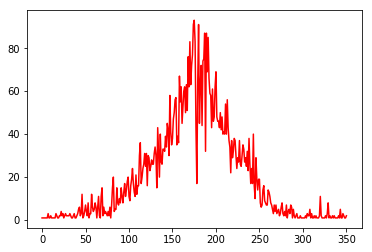

In [28]:
dist = check_for_balance(arr)
plt.plot(dist, "r")
plt.show()


## Need to do some left-right balancing now
> Did that by mirroring all the images which are not at the zero steering value ( x = 400 in my case). And appending the images with a "reversed steering value". <br>
> Reversed steering value was calculated with respect to 400 (i.e  zero steering value ) 

###  Trying to figure out how to use np.fliplr on RGB images before I mirror images 

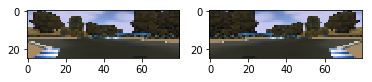

In [57]:
sample_image = np.moveaxis(arr[100][0], 0,2)
flipped = np.fliplr(sample_image)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(sample_image)
axarr[1].imshow(flipped)

In [30]:
## need augmentation -- 

def flip_and_return(np_arr):
    
    np_im = np.moveaxis(np_arr, 0,2)
        
    flipped_img = np.fliplr(np_im)
    
    flipped_img = np.moveaxis(flipped_img, 2,0)
    return flipped_img
    
## span from 231 -- 400 -- 552
def augment_mirror_images(sorted_arr):
    
    for i in range(len(sorted_arr)):
        image = sorted_arr[i][0]
        mirror = flip_and_return(image)
        old_steer_val = sorted_arr[i][1]
        delta = abs(400- old_steer_val)
        if old_steer_val < 400:
            new_steer_val = 400 + delta
        else:
            new_steer_val = 400 - delta
        stack_el = np.array([mirror, new_steer_val ])
        sorted_arr = np.vstack((sorted_arr, stack_el))
    sorted_arr = sorted_arr[sorted_arr[:,1].argsort()]
    return sorted_arr

def random_sample(arr, steer_val):
    slic = []
    for i in arr:
        if i[1] == steer_val:
            slic.append(i)
 
    random_index = random.randint(0, len(slic)-1)
    return slic[random_index]

## Got a symmetric dataset now 
> has an equal number of lefts and rights <br>
> The number of medium rights and medium lefts are a lot, because the track has a lot of mild turns

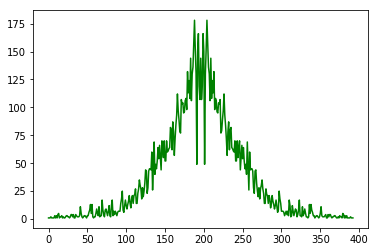

(13794, 2)
178


In [31]:
doo = augment_mirror_images(arr)
dist2 = check_for_balance(doo)
plt.plot(dist2, "g")
plt.show()

print(doo.shape)
print(max(dist2))
np.save("mirrored_new_track.npy", doo)

In [24]:
def augment_data_copies(sorted_arr, gamma):
    
    for i in range(len(sorted_arr)):
        occ = 0
        occ = find_no_occ(sorted_arr, sorted_arr[i][1])
        stack_el = sorted_arr[i]
        while occ < gamma:
            sorted_arr = np.vstack((sorted_arr, stack_el))
            occ += 1 
    return sorted_arr

In [25]:
sorted_arr = doo[doo[:,1].argsort()]
anant = augment_data_copies(sorted_arr, 100)

In [60]:
def chop_the_top(arr, gamma):
    
    for i in range(len(arr)):
        try:
            
            if find_no_occ(arr, arr[i][1]) > gamma:

                arr = np.delete(arr, i)
                i-=1
        except:
            print (arr[i])
            
    return arr

## Now let's calibrate the steering values to give a better "intuition" to the CNN
> It's done by converting the x_co_ordinate of mouse a normalised value <br> with respect to x = 400 as zero and right side as negative 

In [61]:

        
def normalise_steerings(arr):
    for i in range (len(arr)):
        arr[i][1] = 400 - arr[i][1]  ## negative for right 
       
    return arr

In [ ]:
normalised_dataset = normalise_steerings(anant)

steer =  240


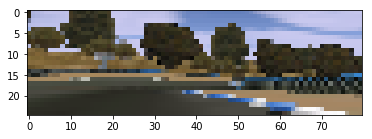

steer =  -4


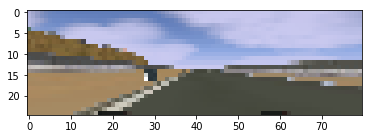

steer =  193


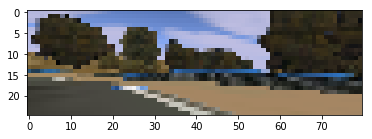

steer =  97


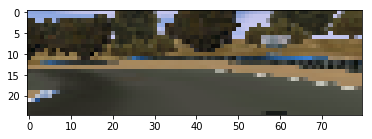

steer =  -100


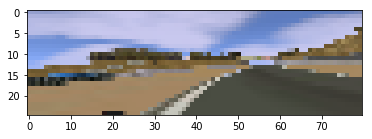

steer =  -195


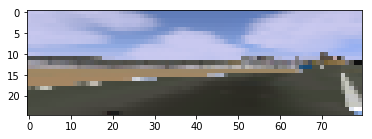

41188


In [35]:
view_samples_with_steering(normalised_dataset, 8000)

print (len(normalised_dataset))

### Time to save the training data
> And hope that it's enough to train the CNN :o

In [29]:
np.save("numpy/fpv_big.npy", normalised_dataset)